In [ ]:
import re
import string
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [11]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shahroz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/shahroz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [13]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df = df.rename(columns={'v1': 'label', 'v2': 'text'})
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [15]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   int64 
 1   text    5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB
None


In [16]:
print(df['label'].value_counts())

0    4825
1     747
Name: label, dtype: int64


In [ ]:
def preprocess_text(text):
    """
    Preprocesses the input text by performing the following operations:
    - Converts the text to lowercase
    - Removes punctuation and special characters
    - Removes stopwords
    - Applies lemmatization
    """
    text = text.lower()

    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text


In [18]:
df['processed_text'] = df['text'].apply(preprocess_text)
df.head()

,label,text,processed_text
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], df['label'], test_size=0.2, random_state=42
)

In [20]:
count_vectorizer = CountVectorizer()
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

In [21]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [22]:
nb_count = MultinomialNB()
nb_count.fit(X_train_count, y_train)
y_pred_nb_count = nb_count.predict(X_test_count)

# Train a Naive Bayes classifier with TF-IDF features
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_nb_tfidf = nb_tfidf.predict(X_test_tfidf)

In [23]:
svm_count = SVC(random_state=42)
svm_count.fit(X_train_count, y_train)
y_pred_svm_count = svm_count.predict(X_test_count)

# Train an SVM classifier with TF-IDF features
svm_tfidf = SVC(random_state=42)
svm_tfidf.fit(X_train_tfidf, y_train)
y_pred_svm_tfidf = svm_tfidf.predict(X_test_tfidf)

In [ ]:
def evaluate_model(y_true, y_pred, model_name, feature_extraction):
    """
    Evaluates the performance of a classification model using various metrics.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred)

    print(f"\nModel: {model_name} with {feature_extraction}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(confusion)

    # Visualize the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name} ({feature_extraction})')
    plt.show()



Model: Naive Bayes with CountVectorizer
Accuracy: 0.9803
Precision: 0.9638
Recall: 0.8867
F1-score: 0.9236
Confusion Matrix:
[[960   5]
 [ 17 133]]


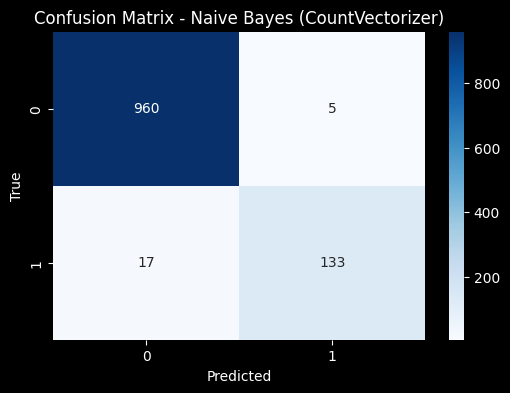


Model: Naive Bayes with TF-IDF
Accuracy: 0.9641
Precision: 1.0000
Recall: 0.7333
F1-score: 0.8462
Confusion Matrix:
[[965   0]
 [ 40 110]]


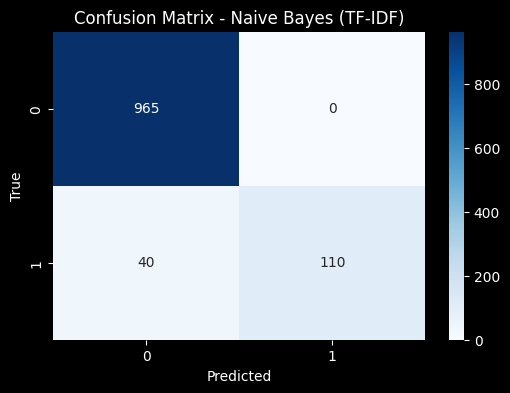


Model: SVM with CountVectorizer
Accuracy: 0.9767
Precision: 0.9921
Recall: 0.8333
F1-score: 0.9058
Confusion Matrix:
[[964   1]
 [ 25 125]]


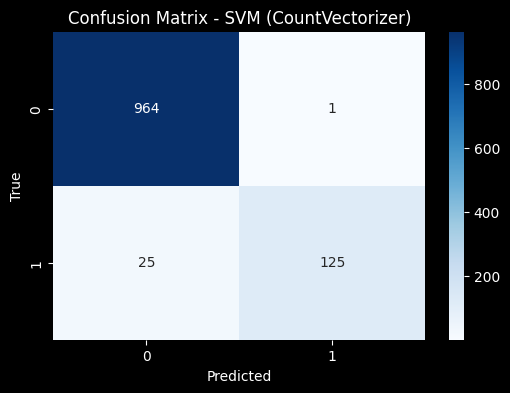


Model: SVM with TF-IDF
Accuracy: 0.9749
Precision: 0.9841
Recall: 0.8267
F1-score: 0.8986
Confusion Matrix:
[[963   2]
 [ 26 124]]


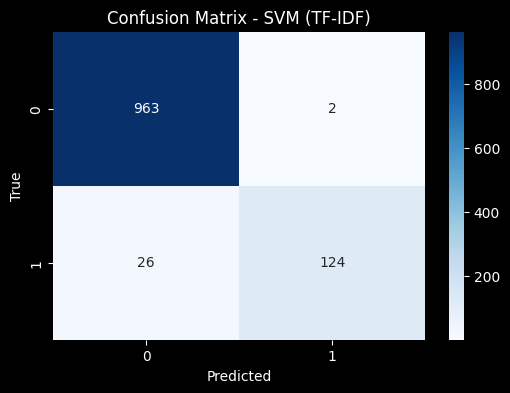

In [25]:
evaluate_model(y_test, y_pred_nb_count, 'Naive Bayes', 'CountVectorizer')
evaluate_model(y_test, y_pred_nb_tfidf, 'Naive Bayes', 'TF-IDF')
evaluate_model(y_test, y_pred_svm_count, 'SVM', 'CountVectorizer')
evaluate_model(y_test, y_pred_svm_tfidf, 'SVM', 'TF-IDF')